In [0]:
from keras.layers import Input, Dense, Conv2D, Dropout, MaxPooling2D, BatchNormalization, Flatten
from keras.models import Model, Sequential
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from keras import backend as K
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image
import re

In [0]:
def preprocessImage(image):
    image = image.resize((32, 32), Image.NEAREST) # resize images
    image = image.convert('L') # convert to grayscale
    return image

In [0]:
def readTrafficSigns(rootpath):
    images = []  # images
    labels = []  # corresponding labels
    # loop over all 42 classes
    for c in range(43):
        prefix = rootpath + '/' + format(c, '05d') + '/'  # subdirectory for class
        gtFile = open(prefix + 'GT-' + format(c, '05d') + '.csv')  # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
        next(gtReader)  # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            image = preprocessImage(Image.open(prefix + row[0]))
            images.append(np.array(image).reshape(32, 32, 1)/255)
            label = np.zeros(43)
            label[int(row[7])] = 1
            labels.append(label)

        gtFile.close()
    return np.asarray(images), np.asarray(labels)

In [0]:
def readTestTrafficSigns(rootpath, num, val):
    images = []  # images
    labels = []  # corresponding labels
    gtFile = open(rootpath + '/GT-final_test.csv')  # annotations file
    gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
    
    if val:
        skip = 0
    else:
        skip = num
        
    for i in range(skip + 1):
        next(gtReader)  # skip header

    for row in gtReader:
        if val and str(num) + ".ppm" in row[0]:
            break
        image = preprocessImage(Image.open(rootpath + '/' + row[0]))
        images.append(np.array(image).reshape(32, 32, 1)/255)
        label = np.zeros(43)
        label[int(row[7])] = 1
        labels.append(label)

    gtFile.close()
    return np.asarray(images), np.asarray(labels)

In [0]:
train_images, train_labels = readTrafficSigns("GTSRB_Final_Training_Images/GTSRB/Final_Training/Images")
val_images, val_labels = readTestTrafficSigns("GTSRB_Final_Test_Images/GTSRB/Final_Test/Images", 5000, True)
test_images, test_labels = readTestTrafficSigns("GTSRB_Final_Test_Images/GTSRB/Final_Test/Images", 5001, False)

In [0]:
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(39209, 32, 32, 1)
(5000, 32, 32, 1)
(7629, 32, 32, 1)


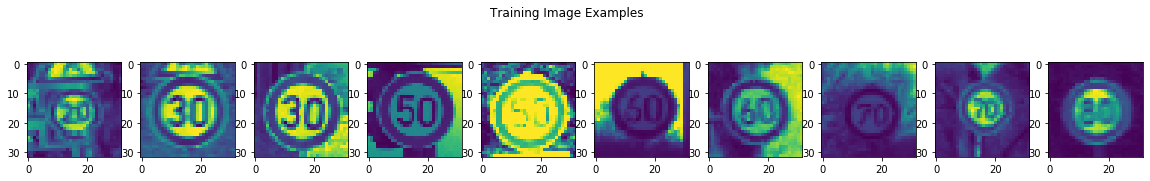

In [0]:
fig, axs = plt.subplots(1, 10)
fig.set_size_inches(20, 3)
fig.suptitle('Training Image Examples')
for i in range(10):
    axs[i].imshow(train_images[i*999].reshape((32,32)))
    plt.show()

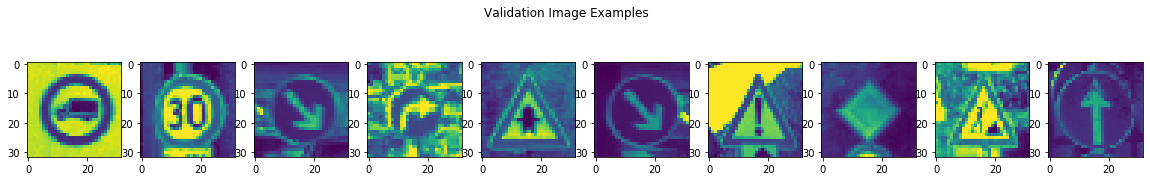

In [0]:
fig, axs = plt.subplots(1, 10)
fig.set_size_inches(20, 3)
fig.suptitle('Validation Image Examples')
for i in range(10):
    axs[i].imshow(val_images[i].reshape((32,32)))

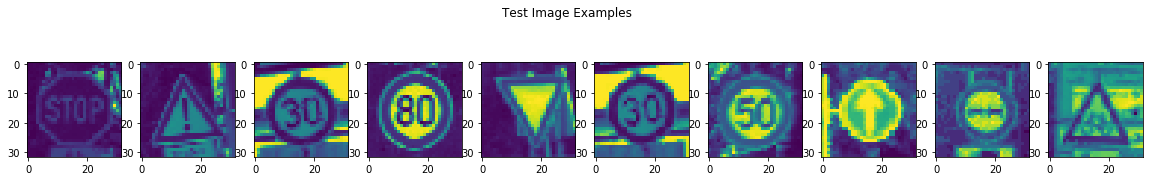

In [0]:
fig, axs = plt.subplots(1, 10)
fig.set_size_inches(20, 3)
fig.suptitle('Test Image Examples')
for i in range(10):
    axs[i].imshow(test_images[i].reshape((32,32)))

In [0]:
def VGGNet(): # VGGNet-16 Model: https://neurohive.io/en/popular-networks/vgg16/
    input_img = Input(shape=(32, 32, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), 2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), 2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    
    layer_flat = Flatten()(x)
    x = Dense(128, activation='relu')(layer_flat)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    layer_out = Dense(43, activation='softmax')(x)

    model = Model(input_img, layer_out)
    
    return model

In [0]:
def LeNet(): #LeNet-5 Model: https://engmrk.com/lenet-5-a-classic-cnn-architecture/
    input_img = Input(shape=(32, 32, 1))

    x = Conv2D(1, (5, 5), activation='relu')(input_img)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(6, (5, 5), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    layer_flat = Flatten()(x)

    x = Dense(120, activation='relu')(layer_flat)

    x = Dense(84, activation='relu')(x)

    layer_out = Dense(43, activation='softmax')(x)

    model = Model(input_img, layer_out)
    
    return model

More info about models: [CNN Architectures: LeNet, AlexNet, VGG, GoogLeNet, ResNet and more…](https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)

In [0]:
def TrainModel(model, modelName, train_images, train_labels, val_images, val_labels,
               epochs=30, batch_size=64, disable_early_stopping=False):
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    
    if disable_early_stopping:
        callbacks=[]
    else:
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
    
    model_train = model.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(val_images, val_labels),
                            shuffle=True,
                            callbacks=callbacks)

    model.save('models/' + modelName + '.h5')
    K.clear_session()
    loss = model_train.history['loss']
    val_loss = model_train.history['val_loss']
    plt.figure()
    plt.plot(val_loss, 'r', label='Val loss')
    plt.plot(loss, 'bo', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('training_and_valid_loss_' + modelName + '.png')
    plt.show()

In [0]:
def CalculateError(real, predicted):
    err = 0
    for i in range(len(predicted)):
        if real[i] != predicted[i]:
            err = err + 1
    err_percent = err/len(predicted)*100
    accuracy = 100 - err_percent
    print('total test data: %d wrong predicted: %d' % (len(predicted), err))
    print('error: %f' % err_percent )
    print('accuracy: %f' % accuracy)
    return err

In [0]:
def Predict(modelPath, test_images, test_labels):
    model = load_model(modelPath)
    predictions = model.predict(test_images)
    pred = []
    real = []
    for i in range(len(predictions)):
        pred.append(np.where(predictions[i] == predictions[i].max())[0])
        real.append(np.where(test_labels[i] == test_labels[i].max())[0])

    CalculateError(real, pred)
    return pred

In [0]:
def getLabel(one_hot_encoded):
    return np.where(one_hot_encoded == one_hot_encoded.max())[0]

## VGGNet Model 

In [0]:
VGGNetModel = VGGNet()
VGGNetModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

Train on 39209 samples, validate on 5000 samples
Epoch 1/30
39209/39209 [==============================] - 65s 2ms/step - loss: 1.9082 - val_loss: 0.5685
Epoch 2/30
39209/39209 [==============================] - 65s 2ms/step - loss: 0.2050 - val_loss: 0.3220
Epoch 3/30
39209/39209 [==============================] - 74s 2ms/step - loss: 0.0800 - val_loss: 0.2999
Epoch 4/30
39209/39209 [==============================] - 66s 2ms/step - loss: 0.0556 - val_loss: 0.3043
Epoch 5/30
39209/39209 [==============================] - 67s 2ms/step - loss: 0.0416 - val_loss: 0.3407
Epoch 6/30
39209/39209 [==============================] - 82s 2ms/step - loss: 0.0443 - val_loss: 0.2796
Epoch 7/30
39209/39209 [==============================] - 75s 2ms/step - loss: 0.0343 - val_loss: 0.2068
Epoch 8/30
39209/39209 [==============================] - 69s 2ms/step - loss: 0.0278 - val_loss: 0.2275
Epoch 9/30
39209/39209 [==============================] - 86s 2ms/step - loss: 0.0267 - val_loss: 0.3896
Epoch 

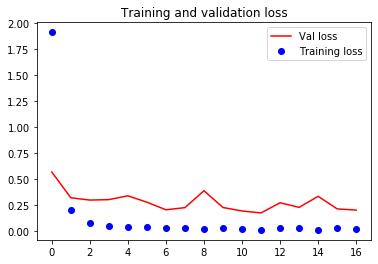

In [0]:
TrainModel(VGGNetModel, "vggnet", train_images, train_labels, val_images, val_labels)

In [0]:
K.clear_session()
p = Predict("models/vggnet.h5", test_images, test_labels)

total test data: 7629 wrong predicted: 326
error: 4.273168
accuracy: 95.726832


In [0]:
p = Predict("models/vggnet.h5", train_images, train_labels)

total test data: 39209 wrong predicted: 57
error: 0.145375
accuracy: 99.854625


In [0]:
p = Predict("models/vggnet.h5", val_i0.01mages, val_labels)

NameError: ignored

## LeNet-5 Model 

In [0]:
LeNetModel = LeNet()
LeNetModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 1)         26        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 6)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               18120     
__________

Train on 39209 samples, validate on 5000 samples
Epoch 1/30
39209/39209 [==============================] - 6s 151us/step - loss: 1.7384 - val_loss: 1.2122
Epoch 2/30
39209/39209 [==============================] - 4s 115us/step - loss: 0.7062 - val_loss: 0.9532
Epoch 3/30
39209/39209 [==============================] - 4s 111us/step - loss: 0.4970 - val_loss: 0.8731
Epoch 4/30
39209/39209 [==============================] - 5s 129us/step - loss: 0.3816 - val_loss: 0.7728
Epoch 5/30
39209/39209 [==============================] - 4s 107us/step - loss: 0.3043 - val_loss: 0.7217
Epoch 6/30
39209/39209 [==============================] - 4s 95us/step - loss: 0.2552 - val_loss: 0.7633
Epoch 7/30
39209/39209 [==============================] - 5s 124us/step - loss: 0.2148 - val_loss: 0.7351
Epoch 8/30
39209/39209 [==============================] - 3s 81us/step - loss: 0.1871 - val_loss: 0.7082
Epoch 9/30
39209/39209 [==============================] - 4s 112us/step - loss: 0.1665 - val_loss: 0.7307

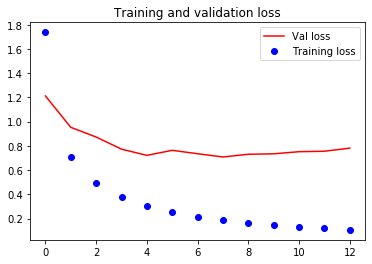

In [0]:
TrainModel(LeNetModel, "lenet5", train_images, train_labels, val_images, val_labels)

In [0]:
K.clear_session()
p = Predict("models/lenet5.h5", test_images, test_labels)

total test data: 7629 wrong predicted: 1077
error: 14.117184
accuracy: 85.882816


In [0]:
p = Predict("models/lenet5.h5", train_images, train_labels)

total test data: 39209 wrong predicted: 1149
error: 2.930450
accuracy: 97.069550


In [0]:
p = Predict("models/lenet5.h5", val_images, val_labels)

total test data: 5000 wrong predicted: 689
error: 13.780000
accuracy: 86.220000


# Adversarial Training

## LeNet-5

First create the adversarial training and test sets.

In [0]:
def readAdversarialData(path, num, val):
    images = []  # images
    labels = []  # corresponding labels
    gtFile = open(path + '/info.csv')  # annotations file
    gtReader = csv.reader(gtFile, delimiter=',')  # csv parser for annotations file
    
    if val:
        skip = 0
    else:
        skip = num
        
    for i in range(skip + 1):
        next(gtReader)  # skip header

    for row in gtReader:
        if val and str(num) + ".jpg" in row[0]:
            break
        image = preprocessImage(Image.open(path + '/' + row[0]))
        images.append(np.array(image).reshape(32, 32, 1)/255)
        label = np.zeros(43)
        label_ind = int(re.search(r'\d+', row[1]).group())
        label[label_ind] = 1
        labels.append(label)

    gtFile.close()
    return images, labels

In [0]:
adv_ep1_images, adv_ep1_labels = readAdversarialData("adversarial/LeNet/epsilon_1", 1000, True) # epsilon = 0.01
adv_ep10_images, adv_ep10_labels = readAdversarialData("adversarial/LeNet/epsilon_10", 1000, True) # epsilon = 0.10
adv_ep15_images, adv_ep15_labels = readAdversarialData("adversarial/LeNet/epsilon_15", 1000, True) # epsilon = 0.15

In [0]:
adv_training_images = []
adv_training_labels = []
adv_training_images.extend(adv_ep1_images[:500])
adv_training_labels.extend(adv_ep1_labels[:500])
adv_training_images.extend(adv_ep10_images[:500])
adv_training_labels.extend(adv_ep10_labels[:500])
adv_training_images.extend(adv_ep15_images[:500])
adv_training_labels.extend(adv_ep15_labels[:500])

In [0]:
np.asarray(adv_training_images).shape

(1500, 32, 32, 1)

In [0]:
adv_test_images = []
adv_test_labels = []
adv_test_images.extend(adv_ep1_images[500:])
adv_test_labels.extend(adv_ep1_labels[500:])
adv_test_images.extend(adv_ep10_images[500:])
adv_test_labels.extend(adv_ep10_labels[500:])
adv_test_images.extend(adv_ep15_images[500:])
adv_test_labels.extend(adv_ep15_labels[500:])

In [0]:
np.asarray(adv_test_images).shape

(629, 32, 32, 1)

In [0]:
new_training_images = []
new_training_labels = []
new_test_images = []
new_test_labels = []

new_training_images.extend(train_images)
new_training_images.extend(adv_training_images)
new_training_labels.extend(train_labels)
new_training_labels.extend(adv_training_labels)

new_test_images.extend(test_images)
new_test_images.extend(adv_test_images)
new_test_labels.extend(test_labels)
new_test_labels.extend(adv_test_labels)

In [0]:
np.asarray(new_training_images).shape

(40709, 32, 32, 1)

In [0]:
np.asarray(new_test_images).shape

(8258, 32, 32, 1)

#### New model that will be trained with adversarial dataset. We use the same structure.

Train on 40709 samples, validate on 5000 samples
Epoch 1/20
40709/40709 [==============================] - 6s 137us/step - loss: 1.8142 - val_loss: 1.1696
Epoch 2/20
40709/40709 [==============================] - 5s 116us/step - loss: 0.8149 - val_loss: 0.9385
Epoch 3/20
40709/40709 [==============================] - 4s 110us/step - loss: 0.6261 - val_loss: 0.7565
Epoch 4/20
40709/40709 [==============================] - 5s 128us/step - loss: 0.5111 - val_loss: 0.7786
Epoch 5/20
40709/40709 [==============================] - 6s 136us/step - loss: 0.4354 - val_loss: 0.6865
Epoch 6/20
40709/40709 [==============================] - 5s 116us/step - loss: 0.3687 - val_loss: 0.6807
Epoch 7/20
40709/40709 [==============================] - 5s 119us/step - loss: 0.3242 - val_loss: 0.6175
Epoch 8/20
40709/40709 [==============================] - 5s 118us/step - loss: 0.2963 - val_loss: 0.6694
Epoch 9/20
40709/40709 [==============================] - 5s 125us/step - loss: 0.2577 - val_loss: 0.60

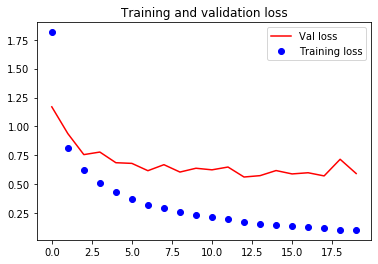

In [0]:
LeNetAdvModel = LeNet()
TrainModel(LeNetAdvModel, "lenet5_adv", np.asarray(new_training_images),
           np.asarray(new_training_labels), val_images, val_labels, epochs=20, disable_early_stopping=True)

In [0]:
K.clear_session()
p = Predict("models/lenet5_adv.h5", np.asarray(new_test_images), np.asarray(new_test_labels))

total test data: 8258 wrong predicted: 1183
error: 14.325503
accuracy: 85.674497


In [0]:
p = Predict("models/lenet5_adv.h5", np.asarray(new_training_images), np.asarray(new_training_labels))

total test data: 40709 wrong predicted: 896
error: 2.200987
accuracy: 97.799013


#### Let's compare the accuracy of the original model and adversarial trained model.

In [0]:
p_adv_original = Predict("models/lenet5.h5", np.asarray(adv_test_images), np.asarray(adv_test_labels))

total test data: 629 wrong predicted: 514
error: 81.717011
accuracy: 18.282989


In [0]:
p_adv_trained = Predict("models/lenet5_adv.h5", np.asarray(adv_test_images), np.asarray(adv_test_labels))

total test data: 629 wrong predicted: 249
error: 39.586645
accuracy: 60.413355


An example of wrongly predicted adversarial sample

In [0]:
def displayExampleImage(img_ind, orig_model_path, adv_model_path, adv_test_images, adv_test_labels, eps_range=[210,420]):
    eps=0
    if img_ind < eps_range[0]:
        eps = 0.01
    elif img_ind < eps_range[1]:
        eps = 0.1
    else:
        eps = 0.15
    fig = plt.figure()
    fig.set_size_inches(20, 3)
    fig.suptitle('Adversarial Sample - epsilon = %.2f' % eps)
    plt.imshow(adv_test_images[img_ind].reshape((32,32)))
    plt.show()

    advModel = load_model(adv_model_path)
    adv_pred = advModel.predict(np.asarray([adv_test_images[img_ind]]))[0]

    origModel = load_model(orig_model_path)
    orig_pred = origModel.predict(np.asarray([adv_test_images[img_ind]]))[0]

    print('Real label: %d' % getLabel(adv_test_labels[img_ind]))
    print('Predicted label by original model: %d' % getLabel(orig_pred))
    print('Predicted label by adversarially trained model: %d' % getLabel(adv_pred))

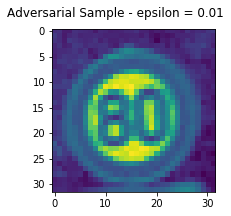

Real label: 5
Predicted label by original model: 3
Predicted label by adversarially trained model: 5


In [0]:
img_ind = 89
displayExampleImage(img_ind, 'models/lenet5.h5', 'models/lenet5_adv.h5', adv_test_images, adv_test_labels, eps_range=[210,420])

## VGGNet

In [0]:
adv_ep1_images2, adv_ep1_labels2 = readAdversarialData("adversarial/VGGNet/epsilon_1", 1000, True) # epsilon = 0.01
adv_ep10_images2, adv_ep10_labels2 = readAdversarialData("adversarial/VGGNet/epsilon_10", 1000, True) # epsilon = 0.10

In [0]:
adv_training_images2 = []
adv_training_labels2 = []
adv_training_images2.extend(adv_ep1_images2[:350])
adv_training_labels2.extend(adv_ep1_labels2[:350])
adv_training_images2.extend(adv_ep10_images2[:350])
adv_training_labels2.extend(adv_ep10_labels2[:350])

In [0]:
np.asarray(adv_training_images2).shape

(700, 32, 32, 1)

In [0]:
adv_test_images2 = []
adv_test_labels2 = []
adv_test_images2.extend(adv_ep1_images2[350:])
adv_test_labels2.extend(adv_ep1_labels2[350:])
adv_test_images2.extend(adv_ep10_images2[350:])
adv_test_labels2.extend(adv_ep10_labels2[350:])

In [0]:
np.asarray(adv_test_images2).shape

(303, 32, 32, 1)

In [0]:
new_training_images2 = []
new_training_labels2 = []
new_test_images2 = []
new_test_labels2 = []

new_training_images2.extend(train_images)
new_training_images2.extend(adv_training_images2)
new_training_labels2.extend(train_labels)
new_training_labels2.extend(adv_training_labels2)

new_test_images2.extend(test_images)
new_test_images2.extend(adv_test_images2)
new_test_labels2.extend(test_labels)
new_test_labels2.extend(adv_test_labels2)

In [0]:
np.asarray(new_training_images2).shape

(39909, 32, 32, 1)

In [0]:
np.asarray(new_test_images2).shape

(7932, 32, 32, 1)

Train on 39909 samples, validate on 5000 samples
Epoch 1/30
39909/39909 [==============================] - 83s 2ms/step - loss: 3.5023 - val_loss: 2.9158
Epoch 2/30
39909/39909 [==============================] - 75s 2ms/step - loss: 2.0524 - val_loss: 1.1353
Epoch 3/30
39909/39909 [==============================] - 79s 2ms/step - loss: 1.1171 - val_loss: 0.6134
Epoch 4/30
39909/39909 [==============================] - 81s 2ms/step - loss: 0.6864 - val_loss: 0.4135
Epoch 5/30
39909/39909 [==============================] - 73s 2ms/step - loss: 0.5065 - val_loss: 0.3366
Epoch 6/30
39909/39909 [==============================] - 75s 2ms/step - loss: 0.4126 - val_loss: 0.2606
Epoch 7/30
39909/39909 [==============================] - 74s 2ms/step - loss: 0.3504 - val_loss: 0.2358
Epoch 8/30
39909/39909 [==============================] - 68s 2ms/step - loss: 0.2978 - val_loss: 0.2556
Epoch 9/30
39909/39909 [==============================] - 68s 2ms/step - loss: 0.2665 - val_loss: 0.2300
Epoch 

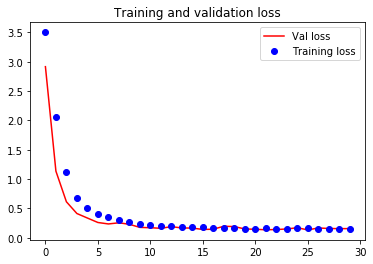

In [0]:
VGGNetAdvModel = VGGNet()
TrainModel(VGGNetAdvModel, "vggnet_adv", np.asarray(new_training_images2),
           np.asarray(new_training_labels2), val_images, val_labels, epochs=30, disable_early_stopping=True)

In [0]:
K.clear_session()
p = Predict("models/vggnet_adv.h5", np.asarray(new_test_images2), np.asarray(new_test_labels2))

total test data: 7932 wrong predicted: 349
error: 4.399899
accuracy: 95.600101


In [0]:
p = Predict("models/vggnet_adv.h5", np.asarray(new_training_images2), np.asarray(new_training_labels2))

total test data: 39909 wrong predicted: 293
error: 0.734170
accuracy: 99.265830


#### Let's compare the accuracy of the original model and adversarial trained model.

In [0]:
p_adv_original = Predict("models/vggnet.h5", np.asarray(adv_test_images2), np.asarray(adv_test_labels2))

total test data: 303 wrong predicted: 139
error: 45.874587
accuracy: 54.125413


In [0]:
p_adv_trained = Predict("models/vggnet_adv.h5", np.asarray(adv_test_images2), np.asarray(adv_test_labels2))

total test data: 303 wrong predicted: 101
error: 33.333333
accuracy: 66.666667


An example of wrongly predicted adversarial sample for VGGNet

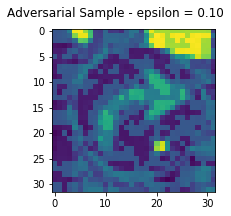

Real label: 33
Predicted label by original model: 14
Predicted label by adversarially trained model: 33


In [0]:
img_ind = 283 # 283
displayExampleImage(img_ind, 'models/vggnet.h5', 'models/vggnet_adv.h5', adv_test_images2, adv_test_labels2, eps_range=[152,304])